# <center><big>AIcrowd - Aircraft localization competition</big> <br /> <medium>(round 1: synchronized receivers)</medium></center>

## <center>Part II - Final solution</center>

### Link to competition page
https://www.aicrowd.com/challenges/cyd-campus-aircraft-localization-competition

### Solution structure

The solution consists of 4 parts:
 1. Data preprocessing and outliers elimination
 2. Multilateration algorithm for points with 3+ measurements available
 3. Filtration of calculated locations from step 2.
 4. Auto-selection of filtered locations from step 3. and extrapolation to the nearest points.

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Data preprocessing and outliers elimination

## Load datasets

I used only the test set (round1_competition.csv file) to train my models and make predictions. I thought that 7 training datasets were recorded at different times and therefore may include clock drifts.

**Here and below by train and test datasets I will assume the training (with known locations) and testing parts of the TEST dataset.**

In [2]:
### Recorded measurements

df = pd.read_csv('test/round1_competition.csv')
print('Data shape:', df.shape)
display(df.head(3))

# Information about sensors

sensors = pd.read_csv('test/sensors.csv')
print('Sensors shape', sensors.shape)
sensors.head(3)

Data shape: (1836730, 9)


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.0,109,51.606740,-0.204849,2590.80,2590.80,2,"[[532,969020406,89],[216,969100125,23]]"
1,2,0.0,840,51.280781,-0.698624,8907.78,8846.82,2,"[[532,976779968,72],[216,976836703,32]]"
2,3,0.0,1819,51.354567,-0.304184,5791.20,5722.62,2,"[[532,980862171,91],[294,980898968,101]]"


Sensors shape (716, 5)


,serial,latitude,longitude,height,type
0,1,46.681067,7.665313,680.9232,SBS-3
1,2,40.337042,-3.770206,735.7872,SBS-3
2,3,0.000000,0.000000,0.0000,SBS-3


### Number of unique aircrafts in train and test

In [3]:
print('Number of unique aircrafts', len(df.aircraft.unique()))

df['test'] = df.latitude.apply(lambda x: int(np.isnan(x)))
print('Number of aircrafts with unknown location', len(df[df.test==1].aircraft.unique()))

Number of unique aircrafts 1635
Number of aircrafts with unknown location 32


### Stations / sensors

In [4]:
# Create a column with all station numbers which provided measurements for a given location
df = df.assign(stations = lambda x: x.measurements.apply(lambda y: [z[0] for z in eval(y)]))

# Find all stations with records for the test
# (It will be shown below that 3+ measurements are required to solve multilateration equations)
test_stations = df[(df.test == 1) & (df.numMeasurements > 2)].stations.values.tolist()

stations = []
for s in test_stations:
    stations += s

print('Number of unique stations', len(set(stations)))

Number of unique stations 33


In [5]:
## So, there are only 33 stations which measurements included in test!

In [6]:
stations = list(set(stations))
print(len(stations))

33


In [7]:
# How many records there are in train with the selected stations

In [8]:
train = (df[(df.test == 0) & (df.numMeasurements > 2)]
 .assign(interest = lambda x: [int(all([i in stations for i in y])) for y in x.stations])
 .loc[lambda x: x.interest == 1]
)

print(train.shape)
train.head(3)

(671959, 12)


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,test,stations,interest
3,4,0.001,719,46.953053,14.289973,10972.80,10820.40,3,"[[149,957322046,48],[143,957512484,102],[133,9...",0,"[149, 143, 133]",1
8,9,0.010,755,49.933136,7.514576,11582.40,11376.66,5,"[[663,991949296,84],[398,992213375,94],[460,99...",0,"[663, 398, 460, 414, 550]",1
9,10,0.012,901,47.345627,6.464218,11399.52,11231.88,4,"[[147,1000432156,69],[470,1000187995,32],[124,...",0,"[147, 470, 124, 474]",1


### Remove location outliers

Some points are far away from their tracks which need to be removed

In [9]:
from tqdm import tqdm

# list of broken ids
broken_id = []

## Loop over aircrafts
for r in tqdm(train.aircraft.unique()):
    # apply a median filter for latitude values
    # true direction
    lat1 = train[train.aircraft==r].latitude.rolling(15).median().values
    # reverse direction
    lat2 = train[train.aircraft==r].latitude.sort_index(ascending=False).rolling(15).median().values[::-1]
    # combine them together
    lat = [0.5*(x+y) if not np.isnan(x) and not np.isnan(y) else x if not np.isnan(x) else y for x, y in zip(lat1, lat2)]

    # apply a median filter for longitude values
    # true direction
    lon1 = train[train.aircraft==r].longitude.rolling(15).median().values
    # reverse direction
    lon2 = train[train.aircraft==r].longitude.sort_index(ascending=False).rolling(15).median().values[::-1]
    # combine them together
    lon = [0.5*(x+y) if not np.isnan(x) and not np.isnan(y) else x if not np.isnan(x) else y for x, y in zip(lon1, lon2)]
    
    # filter outliers by a threshold
    lat = train[train.aircraft==r].latitude.values - np.array(lat)
    lon = train[train.aircraft==r].longitude.values - np.array(lon)
    
    ind = np.unique(np.r_[np.where(abs(lat) > 1)[0], np.where(abs(lon) > 1)[0]])

    broken_id += train[train.aircraft==r].id.values[ind].tolist()
    
len(broken_id)

100%|██████████| 1068/1068 [00:22<00:00, 47.32it/s]


1437

In [10]:
# Number of outliers found

In [11]:
len(broken_id)

1437

In [12]:
# Remove outliers

In [13]:
train = train[~train.id.isin(broken_id)]
print(train.shape)

(670522, 12)


## Coordinate transformation from WGS84 to cartesian

Copy from here:
https://competition.opensky-network.org/documentation.html

In [14]:
class P3:
    def __init__(self, latitude, longitude, height):
        self.latitude = latitude
        self.longitude = longitude
        self.height = height
        
    # convert decimal degrees to radians
    def rad(self, degrees):
        return degrees * np.pi / 180.

    # convert radians to decimal degrees
    def deg(self, radians):
        return 180 * radians / np.pi

    # convert WSG84 coordinates to cartesian ones
    def to_cartesian(self):
        lat = self.rad(self.latitude)
        lon = self.rad(self.longitude)

        # WSG84 ellipsoid constants
        a = 6378137
        e2 = 6.69437999014e-3 #8.1819190842622e-2

        # prime vertical radius of curvature
        N = a / np.sqrt(1 - e2 * pow(np.sin(lat),2))

        return( (N + self.height) * np.cos(lat) * np.cos(lon),
                (N + self.height) * np.cos(lat) * np.sin(lon),
                ((1 - e2) * N + self.height) * np.sin(lat) )

# 3D distance between WSG84 coordinates
def dist3d(p1, p2):
    x1, y1, z1 = p1.to_cartesian()
    x2, y2, z2 = p2.to_cartesian()
        
    return np.sqrt(pow(x1-x2,2) + pow(y1-y2,2) + pow(z1-z2,2))

## Altitude measurements

Text(0, 0.5, 'geoAltitude')

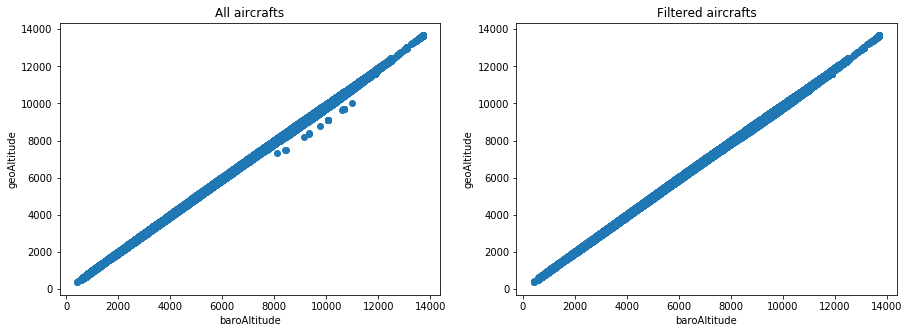

In [15]:
figsize(15, 5)

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.scatter(train.baroAltitude,
            train.geoAltitude)
ax1.set_title('All aircrafts')
ax1.set_xlabel('baroAltitude')
ax1.set_ylabel('geoAltitude')

# 2 aircrafts seems to have outliers
ax2 = f.add_subplot(122)
ax2.scatter(train[~train.aircraft.isin([1120, 415])].baroAltitude,
            train[~train.aircraft.isin([1120, 415])].geoAltitude)
ax2.set_title('Filtered aircrafts')
ax2.set_xlabel('baroAltitude')
ax2.set_ylabel('geoAltitude')

In [16]:
# Apply spline interpolation to find geoAltitude as a function of baroAltitude
# (Linear interpolation shows worse result)

In [17]:
from scipy.interpolate import splrep, splev

ind = np.argsort(train[~train.aircraft.isin([1120, 415])].baroAltitude.values)

spl = splrep(train[~train.aircraft.isin([1120, 415])].baroAltitude.values[ind],
             train[~train.aircraft.isin([1120, 415])].geoAltitude.values[ind],
             k=2, t=[5000, 10000], task=-1)

In [18]:
# Check result

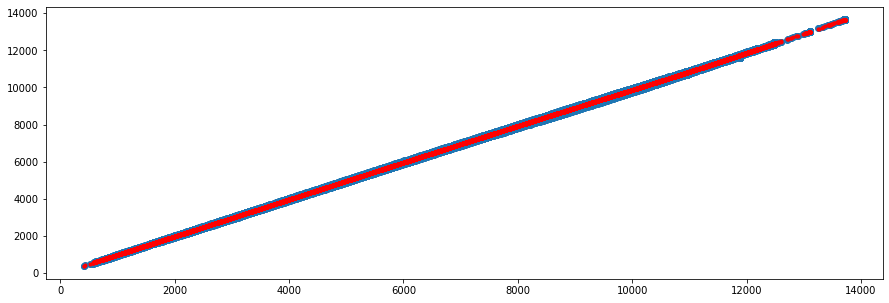

In [19]:
figsize(15, 5)

plt.scatter(train[~train.aircraft.isin([1120, 415])].baroAltitude,
            train[~train.aircraft.isin([1120, 415])].geoAltitude)
plt.plot(train[~train.aircraft.isin([1120, 415])].baroAltitude.values,
         splev(train[~train.aircraft.isin([1120, 415])].baroAltitude.values, spl), 'r.')

In [20]:
## Remove two tracks from train

In [21]:
train = train[~train.aircraft.isin([1120, 415])]
print(train.shape)

(670206, 12)


## Create dictionaries to work with stations

Below I will need to create matrices and indices for the selected 33 stations.
Here I define some hash-map structures to get direct access to some information about a station by its number:

 | Name | Input | Output |
 |------|-------|--------|
 | st_dict | station number | station order |
 | st_dict_rev | station order | station number |
 | st_loc | station number | station location (P3 class instance) |
 | st_lat | station number | station latitude |
 | st_lon | station number | station longitude |

In [22]:
# returns station order by station number
# example for station 10: st_dict[10] = 0
st_dict = {}

# reverse map
# example for station 10: st_dict_rev[0] = 10
st_dict_rev = {}

st_loc = {}  # dict of P3 class instances for use in dist3d function
st_lat = {}  # station latitudes
st_lon = {}  # station longitudes

for i, s in enumerate(sorted(stations)):
    st_dict[s] = i
    st_dict_rev[i] = s
    
    station_geo = sensors.loc[sensors.serial==s, ['latitude', 'longitude', 'height']].values[0]
    st_loc[s] = P3(*station_geo)
    st_lat[s] = station_geo[0]
    st_lon[s] = station_geo[1]
    
st_dict

{10: 0,
 14: 1,
 121: 2,
 124: 3,
 130: 4,
 131: 5,
 132: 6,
 133: 7,
 134: 8,
 141: 9,
 142: 10,
 143: 11,
 147: 12,
 149: 13,
 208: 14,
 216: 15,
 247: 16,
 257: 17,
 263: 18,
 294: 19,
 299: 20,
 327: 21,
 398: 22,
 414: 23,
 460: 24,
 470: 25,
 474: 26,
 532: 27,
 550: 28,
 598: 29,
 632: 30,
 663: 31,
 670: 32}

## Station time measurements

In this round all stations are assumed to have GPS sensors and therefore synchronized.

I will define here two types of time for each station:
 - raw time measurements: timestamps measured by a station;
 - true time measurements: timestamps minus time required to a radiowave to pass distance between an aircraft and a station.

In [23]:
## train set

N = train.shape[0]
T = np.zeros([N, len(st_dict)])  # true station time measurements
T0 = np.zeros([N, len(st_dict)])  # raw station time measurements

lat = train.latitude.values
lon = train.longitude.values
hgt = train.geoAltitude.values
meas = train.measurements.values

for i in tqdm(range(N)):
    for w in eval(meas[i]):
        # true time measurement = station_measured_time - distance_to_aircraft / speed_of_light
        T[i, st_dict[w[0]]] = w[1] - dist3d(st_loc[w[0]], P3(lat[i], lon[i], hgt[i]))/0.299792458
        # raw time measurements 
        T0[i, st_dict[w[0]]] = w[1]
        
        
## test set
        
test = df[(df.test==1)&(df.numMeasurements>2)]

N = test.shape[0]
Ttest = np.zeros([N, len(st_dict)])
meas = test.measurements.values

for i in tqdm(range(N)):
    for w in eval(meas[i]):
        # only raw time measurements available
        Ttest[i, st_dict[w[0]]] = w[1]

100%|██████████| 72136/72136 [00:01<00:00, 50672.58it/s]


## Cython code

Cython is a powerful extension of Python which allows to include some "C++ like" code into Python programms.
Cython significantly decrease computation time of heavy used functions.
Each Cython function has to be wrapped by a corresponding Python function (see below).

In [25]:
# load Cython extension
%load_ext Cython

In [26]:
%%cython

## Cython code in this cell

# load libraries
cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport pi, sqrt, sin, cos, pow


# WSG84 ellipsoid constants
cdef:
    double wgs_a = 6378137  # [m]
    double wgs_e2 = 0.00669437999014


# --------------------------------------------------------------------
# Cython function to convert WGS84 coordinates to cartesian
# --------------------------------------------------------------------

cdef wgs2cart_c(double latitude, double longitude, double height):
    cdef:
        double lat = pi * latitude / 180.
        double lon = pi * longitude / 180.
        
        # prime vertical radius of curvature
        double N = wgs_a / sqrt(1 - wgs_e2 * pow(sin(lat), 2))
        double cart[3]

    cart[0] = (N + height) * cos(lat) * cos(lon)
    cart[1] = (N + height) * cos(lat) * sin(lon)
    cart[2] = ((1 - wgs_e2) * N + height) * sin(lat)
    
    return cart


# --------------------------------------------------------------------
# Cython function to calculate distance in 3D space
# --------------------------------------------------------------------

cdef dist3d_c(double latitude1, double longitude1, double height1,
              double latitude2, double longitude2, double height2):
    
    cdef double cart1[3], cart2[3]
    
    cart1 = wgs2cart_c(latitude1, longitude1, height1)
    cart2 = wgs2cart_c(latitude2, longitude2, height2)
    
    return sqrt(pow(cart1[0] - cart2[0], 2) + pow(cart1[1] - cart2[1], 2) + pow(cart1[2] - cart2[2], 2))


# --------------------------------------------------------------------
# Python wrapper for Cython function to calculate distance in 3D space
# --------------------------------------------------------------------

def dist3d_p(double lat1, double lon1, double hgt1,
             double lat2, double lon2, double hgt2):
    return dist3d_c(lat1, lon1, hgt1, lat2, lon2, hgt2)


# --------------------------------------------------------------------
# Cython function to calculate residual error for multilateration equations
#
# Input:
#   - lat: aircraft latitude [deg]
#   - lon: aircraft longitude [deg]
#   - hgt: aircraft geoAltitude [m]
#   - st_loc: stations' locations in format (lat_1, lon_1, hgt_1, ..., lat_n, lon_n, hgt_n), where n - number of stations
#   - st_t: stations' measured time [s]
#   - st_dt: delta true time between two stations in format (T_1-T_0, T_2-T_0, ... T_n-T_0) [s] 
#   - st_sigma: standard deviation of delta T measurents for given two stations in format (sigma_01, ..., sigma_0n) [s] 
#   - N: number of stations
#
# Output:
#   - residual error as SQRT(SUM(error_i) / N)
# --------------------------------------------------------------------

cdef func_c(double lat,
            double lon,
            double hgt,
            double* st_loc,
            double* st_t,
            double* st_dt,
            double* st_sigma,
            int N):
    
    cdef:
        double err = 0
        double dt, ds
        double sigma
        int i, j
    
    # two loops over all unique combinations of stations
    for i in range(N-1):
        for j in range(i+1, N):
            if i == 0:
                # delta true time and sigma are directly provided
                dt = st_dt[j-1]
                sigma = st_sigma[j-1]
            else:
                # T_j - T_i = (T_j - T_0) - (T_i - T_0)
                dt = st_dt[j-1] - st_dt[i-1]
                sigma = max(st_sigma[i-1], st_sigma[j-1])
            
            # dt [in seconds!] = T0_j - T0_i - (T_j - T_i)
            dt = st_t[j] - st_t[i] - dt
            # ds [in meters] = delta distance between aircraft and two stations in [m]
            ds = dist3d_c(lat, lon, hgt, st_loc[3*j], st_loc[3*j+1], st_loc[3*j+2]) - dist3d_c(lat, lon, hgt, st_loc[3*i], st_loc[3*i+1], st_loc[3*i+2])
            # residual error, where 299792458 is the speed of light in [m/s]
            err += pow(dt - ds/299792458., 2) / pow(sigma, 2)
    return sqrt(err / float(N))


# --------------------------------------------------------------------
# Python wrapper for Cython function
# --------------------------------------------------------------------

def func_p(x,
         hgt,
         np.ndarray[np.double_t, ndim=1] st_loc,
         np.ndarray[np.double_t, ndim=1] st_t,
         np.ndarray[np.double_t, ndim=1] st_dt,
         np.ndarray[np.double_t, ndim=1] st_sigma):
    
    N = len(st_t)
    result = func_c(
        x[0], x[1], hgt,
        <double*> st_loc.data,
        <double*> st_t.data,
        <double*> st_dt.data,
        <double*> st_sigma.data,
        N)
    
    return result

# 2. Multilateration algorithm

#### Theory

Well known equation for one station in cartesian coordinates:

$ c \left(T_{0} - T\right) = d(\vec{r_{0}}, \vec{r}) = \sqrt{(x_{0} - x)^{2} + (y_{0} - y)^{2} + (z_{0} - z)^{2}}$

where $c$ is the speed of light; $T_{0}$ - station raw time measurement; $T$ - station true time measurement; $x_{0}$, $y_{0}$, $z_{0}$ and $x$, $y$, $z$ - cartesian coordinates for a station and aircraft (at time $T$) correspondigly. 

Applied to the current task, there are three variables in this equation: $T$, $x$ and $y$ ($z$ is predicted using baroAltitude, station location is known). So, minimimum three equations (three station measurements) are required. I would like to rewrite this equation for the case of two stations measurements as follows:

$ c \left(T_{02} - T_{01}\right) - c (T_{2} - T_{1}) = d(\vec{r_{2}}, \vec{r}) - d(\vec{r_{1}}, \vec{r})$

where $T_{02}$, $T_{01}$ are stations raw time measurements; $T_{2} - T_{1}$ is clock shift between two stations; $d(\vec{r_{2}}, \vec{r})$, $d(\vec{r_{1}}, \vec{r})$ are distances between two stations and the aircraft.

#### Implementation

It was shown above that at least three stations measurements are required to find aircraft location. However, I would prefer to find locations of all records with 4+ measurements first as in this case I would expect better convergence (due to extra measurement) and estimation of location error included. If a record has more than 4 measurements, I will calculate location multiple times for different combinations of 4 stations and select the one with minimum residual error. So, my algorithm consists of the following steps:
 - find all combinations of 4 stations available in records;
 - for each combination of stations:
     - fit NearestNeighbours model on all delta T0 (raw time) data from train;
     - for each record find the closest 10 points in train by delta Ttest using NearestNeighbours model;
     - estimate initial location for a record as average value for latitude and longitude across the closest train points;
     - estimate clock shift between each pair of stations as a median value of clock shifts across the closest train points;
     - use fmin_l_bgfs_b nonlinear optimization method with Cython function for residual error to calculate precise location for a record;
     - save new location if there is no location for this record yet or if residual error from the previous estimation is bigger.
 - find all the rest records where 3 stations are available;
 - for each combination of stations:
     - repeat all the steps as for combinations of 4+ stations;
     - save all new locations found.

## Solve equations for all combinations of 4 stations available

In [27]:
## all combinations of 4 stations

res = []

for i in tqdm(range(Ttest.shape[1])):
    for j in range(i+1, Ttest.shape[1]):
        for k in range(j+1, Ttest.shape[1]):
            for m in range(k+1, Ttest.shape[1]):
                if len(np.where((Ttest[:, i]!=0) &
                                (Ttest[:, j]!=0) &
                                (Ttest[:, k]!=0) &
                                (Ttest[:, m]!=0))[0]) > 0:
                    res += [[i, j, k, m]]

100%|██████████| 33/33 [01:27<00:00,  2.66s/it]


In [28]:
# resulting array
result_test = -1 * np.ones([test.shape[0], 3])

# geoAltitude for test
height_test = splev(test.baroAltitude.values, spl)

In [29]:
# indexes of 4+ measurements
ind4 = np.where(test.numMeasurements>3)[0]

In [30]:
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import fmin_l_bfgs_b

# loop over combinations of stations
for res_i in tqdm(range(len(res))):
    # stations available
    t_ind = res[res_i]

    # indexes of records in test
    ind = ind4[np.where((Ttest[ind4, t_ind[0]]!=0) &
                        (Ttest[ind4, t_ind[1]]!=0) &
                        (Ttest[ind4, t_ind[2]]!=0) &
                        (Ttest[ind4, t_ind[3]]!=0))[0]]

    # indexes of records in train
    ind1 = np.where((T0[:, t_ind[0]]!=0) &
                    (T0[:, t_ind[1]]!=0) &
                    (T0[:, t_ind[2]]!=0) &
                    (T0[:, t_ind[3]]!=0))[0]

    # form a search matrix. T1 - delta Ttest for test, T2 - delta T0 for train
    for i, j in enumerate(t_ind[1:]):
        if i==0:
            T1 = (Ttest[ind, j] - Ttest[ind, t_ind[0]]).reshape(-1, 1)
            T2 = (T0[ind1, j] - T0[ind1, t_ind[0]]).reshape(-1, 1)
        else:
            T1 = np.c_[T1, (Ttest[ind, j] - Ttest[ind, t_ind[0]]).reshape(-1, 1)]
            T2 = np.c_[T2, (T0[ind1, j] - T0[ind1, t_ind[0]]).reshape(-1, 1)]

    # If there is less than 10 points in train available -> break
    if T2.shape[0] < 10:
        continue
    
    # train ML model
    neigh = NearestNeighbors(n_neighbors=10)
    neigh.fit(T2)

    # delta true time T between stations
    dt = np.zeros([len(ind), 3])  # size 3 = 4 - 1
    
    # initial position
    x0 = np.zeros(2)

    # loop over records in test
    for i in range(T1.shape[0]):
        # indexes in train of closest points to a test point
        ii = ind1[neigh.kneighbors(T1[i, :].reshape(1, 3))[1][0]]

        # initial location estimation = mean value across nearest points from train
        x0[0] = np.mean(train.latitude.values[ii])
        x0[1] = np.mean(train.longitude.values[ii])

        # fill in dt with a median value
        for j, k in enumerate(t_ind[1:]):
            dt[i, j] = np.median((T[ii, k] - T[ii, t_ind[0]]).flatten())

    # stations locations
    q_loc = sensors.loc[sensors.serial.isin([st_dict_rev[a] for a in t_ind]), ['latitude', 'longitude', 'height']].as_matrix().flatten()
    # stations time measurements
    tx = np.c_[Ttest[ind, t_ind[0]], Ttest[ind, t_ind[1]], Ttest[ind, t_ind[2]], Ttest[ind, t_ind[3]]]
    # decided to use the same sigma values for all stations
    sigma = np.array([100, 100, 100])/1e9

    # temporary storage for results
    loc_test = np.zeros([len(ind), 3])

    # loop over records in test
    for i in range(len(ind)):
        q = fmin_l_bfgs_b(func_p, x0, approx_grad=1, args=(height_test[ind[i]], q_loc, tx[i, :]/1e9, (dt[i, :])/1e9, sigma))  # tx and dt in seconds!
        loc_test[i, :2] = q[0]  # save location
        loc_test[i, 2] = q[1]  # save error
        
    # loop over records in test
    # save results
    for i, j in enumerate(ind):
        if (result_test[j, 2] == -1) or (loc_test[i, 2] < result_test[j, 2]):
            result_test[j, :] = loc_test[i, :]

100%|██████████| 4054/4054 [13:16<00:00,  5.09it/s]  


## Solve equations for all the rest records where 3 stations are available

In [31]:
## all combinations of 3 stations

res = []

ii = np.where(result_test[:, 2]==-1)[0]

for i in tqdm(range(Ttest.shape[1])):
    for j in range(i+1, Ttest.shape[1]):
        for k in range(j+1, Ttest.shape[1]):
            if len(np.where((Ttest[ii, i]!=0) &
                            (Ttest[ii, j]!=0) &
                            (Ttest[ii, k]!=0))[0]) > 0:
                res += [[i, j, k]]

100%|██████████| 33/33 [00:03<00:00,  9.47it/s]


In [32]:
ind3 = np.where(result_test[:, 2]==-1)[0]

# loop over combinations of stations
for res_i in tqdm(range(len(res))):
    # stations available
    t_ind = res[res_i]

    # # indexes of records in test
    ind = ind3[np.where((Ttest[ind3, t_ind[0]]!=0) &
                        (Ttest[ind3, t_ind[1]]!=0) &
                        (Ttest[ind3, t_ind[2]]!=0))[0]]

    # # indexes of records in train
    ind1 = np.where((T0[:, t_ind[0]]!=0) &
                    (T0[:, t_ind[1]]!=0) &
                    (T0[:, t_ind[2]]!=0))[0]

    # form search matrix. T1 - delta Ttest for test, T2 - delta T0 for train
    for i, j in enumerate(t_ind[1:]):
        if i==0:
            T1 = (Ttest[ind, j] - Ttest[ind, t_ind[0]]).reshape(-1, 1)
            T2 = (T0[ind1, j] - T0[ind1, t_ind[0]]).reshape(-1, 1)
        else:
            T1 = np.c_[T1, (Ttest[ind, j] - Ttest[ind, t_ind[0]]).reshape(-1, 1)]
            T2 = np.c_[T2, (T0[ind1, j] - T0[ind1, t_ind[0]]).reshape(-1, 1)]

    # If there is less than 10 points in train available -> break
    if T2.shape[0] < 10:
        continue
        
    # train ML model
    neigh = NearestNeighbors(n_neighbors=10)
    neigh.fit(T2)

    # delta true time T between stations
    dt = np.zeros([len(ind), 2])
    
    # initial position
    x0 = np.zeros(2)

    # loop over records in test
    for i in range(T1.shape[0]):
        # indexes in train of closest points to a test point
        ii = ind1[neigh.kneighbors(T1[i, :].reshape(1, 2))[1][0]]

        # initial location estimation
        x0[0] = np.mean(train.latitude.values[ii])
        x0[1] = np.mean(train.longitude.values[ii])


        # fill in dt with a median value
        for j, k in enumerate(t_ind[1:]):
            dt[i, j] = np.median((T[ii, k] - T[ii, t_ind[0]]).flatten())

    # stations locations
    q_loc = sensors.loc[sensors.serial.isin([st_dict_rev[a] for a in t_ind]), ['latitude', 'longitude', 'height']].as_matrix().flatten()
    # stations time measurements
    tx = np.c_[Ttest[ind, t_ind[0]], Ttest[ind, t_ind[1]], Ttest[ind, t_ind[2]]]
    # decided to use the same sigma values for all stations
    sigma = np.array([100, 100])/1e9

    # temporary storage for results
    loc_test = np.zeros([len(ind), 3])

    # loop over records in test
    for i in range(len(ind)):
        q = fmin_l_bfgs_b(func_p, x0, approx_grad=1, args=(height_test[ind[i]], q_loc, tx[i, :]/1e9, (dt[i, :])/1e9, sigma))
        loc_test[i, :2] = q[0]
        loc_test[i, 2] = q[1]
        
    # loop over records in test
    # save results
    for i, j in enumerate(ind):
        result_test[j, :] = loc_test[i, :]

100%|██████████| 776/776 [01:37<00:00,  7.97it/s]


In [33]:
# Save calculated locations and errors

test['latitude'] = result_test[:, 0]
test['longitude'] = result_test[:, 1]
test['geoAltitude'] = height_test
test['err'] = result_test[:, 2]

In [34]:
test.to_csv('test_preprocessed.csv', index=False)

# 3. Filtration of calculated locations from step 2

After step 2 a lot of points have incorrect locations, so before moving forward some filtering is required.

I found that combination of the following three filters remove almost all outliers. The filters are:
 - first DBSCAN filter. This filter removes points that are not dense enough;
 - direction filter (definition below). This filter checks that points are on the same line;
 - second DBSCAN filter. Removes the rest small clusters of dense points which haven't been removed by the previous filters.
 
I was searching filter parameters manually for each aircraft track in test although most of them have the same value across tracks. Step 4 also includes some filtration, so it is not necessary to remove all outliers.
 
#### Direction filter

Consider three points $P_{1}$, $P_{2}$ and $P_{3}$, where corresponding times are $t_{1} < t_{2} < t_{3}$.
Then, we can calculate distances between them and create a difference as
$\Delta{d} = d(P_{3}, P_{1}) - d(P_{3}, P_{2}) - d(P_{2}, P_{1})$

Parameters of this filter are:
 - k: a step so that $P_{2} = P[j]$, $P_{3} = P[j + k]$ and $P_{1} = P[j - k]$
 - threshold: remove points where $\Delta{d} > threshold$

In [35]:
# Download points from step 2
test = pd.read_csv('test_preprocessed.csv')

In [36]:
# A list of aircraft numbers in test so that to work with them as r[i] where i = 0, 1, ..., 31
r = test.aircraft.unique()
r

array([1839, 2109, 1428,  995,  172, 2669, 1348, 1076, 2514,  149, 1305,
        741, 2818, 2231, 2140, 1552, 2071, 1031, 2027, 1503, 1539, 1434,
        350, 1984, 1855, 1429, 1380,  429, 1979,  141,  253, 2771])

In [37]:
from sklearn.cluster import DBSCAN
    
def filter_track(aircraft_id,
                 lat_gr=None, lat_ls=None,
                 lon_gr=None, lon_ls=None,
                 db1_eps=0.02, db1_n=5,
                 k=3, rad=20,
                 db2_eps=None, db2_n=None,
                 plot=None):
    
    # remove points with residual error > 1
    da = test[test.aircraft==r[aircraft_id]].loc[lambda x: x.err<1]
    
    # filter latitude and / or longitude if required
    if lat_gr:
        da = da[da.latitude > lat_gr]
        
    if lat_ls:
        da = da[da.latitude < lat_ls]
        
    if lon_gr:
        da = da[da.longitude > lon_gr]
        
    if lon_ls:
        da = da[da.longitude < lon_ls]
        
    #print('Init', da.shape)
    
    # plot points before main filtration
    if plot == 'init':
        figsize(15, 10)
        plt.scatter(da.longitude, da.latitude, c=np.log10(da.err))
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.colorbar()
        return da
    
    
    # First filter DBSCAN
    if (db1_eps is not None) and (db1_n is not None):
        # fit DBSCAN
        db = DBSCAN(eps=db1_eps, min_samples=db1_n).fit(da[['latitude', 'longitude']].as_matrix())
        # apply filter
        da = da.iloc[np.where(db.labels_!=-1)[0]]
        #print('DB1', da.shape)
        
        # plot remaining points
        if plot == 'db1':
            figsize(15, 10)
            plt.scatter(da.longitude, da.latitude, c=np.log10(da.err))
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.colorbar()
            return da

        
    # Direction filter
    if (k is not None) and (rad is not None):
        lat = da.latitude.values
        lon = da.longitude.values
        hgt = da.geoAltitude.values

        # Absolute difference between distances in meters between three stations.
        # k - step, rad - threshold
        d2 = np.abs(np.array([dist3d(P3(lat[i+k], lon[i+k], hgt[i+k]), P3(lat[i-k], lon[i-k], hgt[i-k])) -
                              dist3d(P3(lat[i+k], lon[i+k], hgt[i+k]), P3(lat[i], lon[i], hgt[i])) -
                              dist3d(P3(lat[i], lon[i], hgt[i]), P3(lat[i-k], lon[i-k], hgt[i-k])) for i in range(k, da.shape[0]-k)]))
        # apply filter
        da = da.iloc[np.where(d2 < rad)[0]+k]
        #print('LinFilt', da.shape)
        
        # plot remaining points
        if plot == 'linfilt':
            figsize(15, 10)
            plt.scatter(da.longitude, da.latitude, c=np.log10(da.err))
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.colorbar()
            return da
    
    
    # Second filter DBSCAN
    if (db2_eps is not None) and (db2_n is not None):
        # fit DBSCAN
        db = DBSCAN(eps=db2_eps, min_samples=db2_n).fit(da[['latitude', 'longitude']].as_matrix())
        # apply filter
        da = da.iloc[np.where(db.labels_!=-1)[0]]
        #print('DB2', da.shape)
        
        # plot remaining points
        if plot == 'db2':
            figsize(15, 10)
            plt.scatter(da.longitude, da.latitude, c=np.log10(da.err))
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.colorbar()
            return da

    return da

## Test filters

### Points from step 2 before filtration

Aircraft number 1428


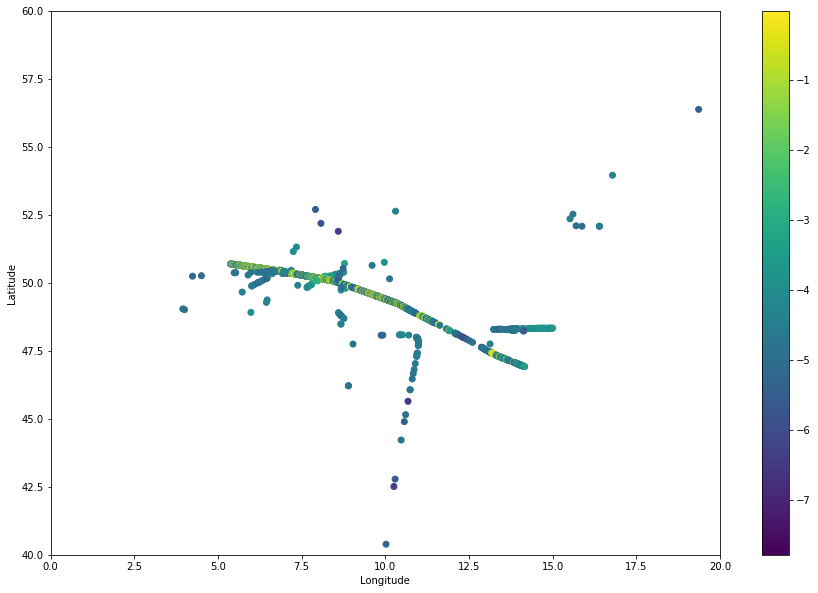

In [38]:
print('Aircraft number', r[2])

_ = filter_track(2,
             lat_gr=None, lat_ls=None,
             lon_gr=None, lon_ls=None,
             db1_eps=0.05, db1_n=5,
             k=3, rad=5,
             db2_eps=0.05, db2_n=5,
             plot='init')

_ = plt.xlim([0, 20])
_ = plt.ylim([40, 60])

### First DBSCAN filter

Aircraft number 1428


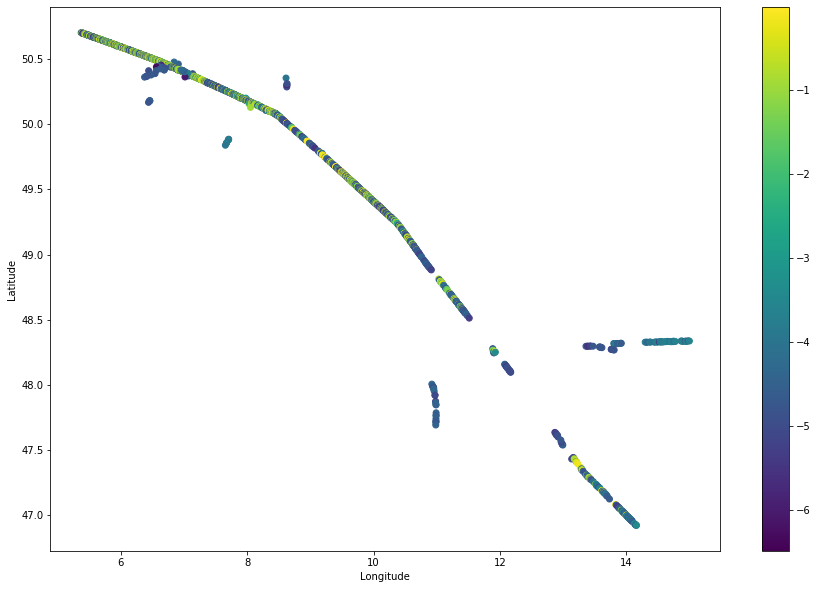

In [39]:
print('Aircraft number', r[2])

_ = filter_track(2,
             lat_gr=None, lat_ls=None,
             lon_gr=None, lon_ls=None,
             db1_eps=0.05, db1_n=5,
             k=3, rad=5,
             db2_eps=0.05, db2_n=5,
             plot='db1')

### Direction filter

Aircraft number 1428


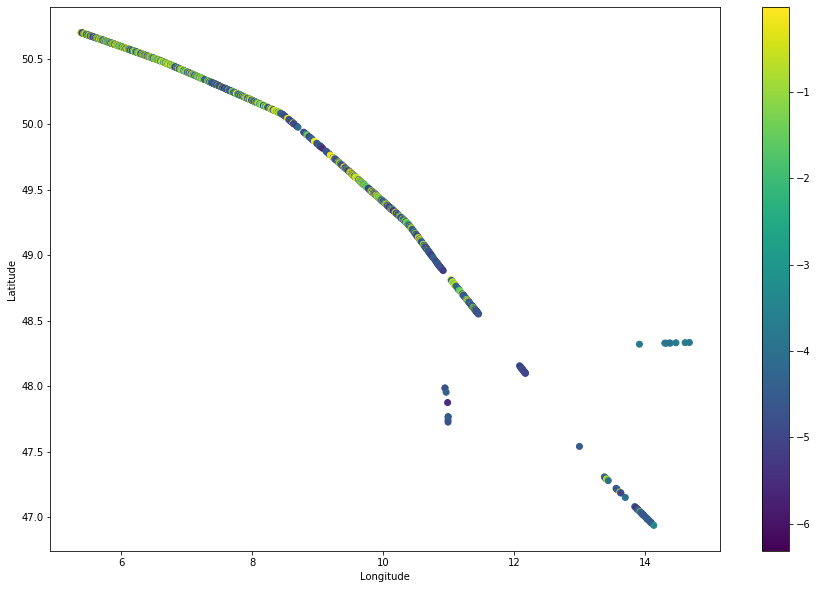

In [40]:
print('Aircraft number', r[2])

_ = filter_track(2,
             lat_gr=None, lat_ls=None,
             lon_gr=None, lon_ls=None,
             db1_eps=0.05, db1_n=5,
             k=3, rad=5,
             db2_eps=0.05, db2_n=5,
             plot='linfilt')

### Second DBSCAN filter

Aircraft number 1428


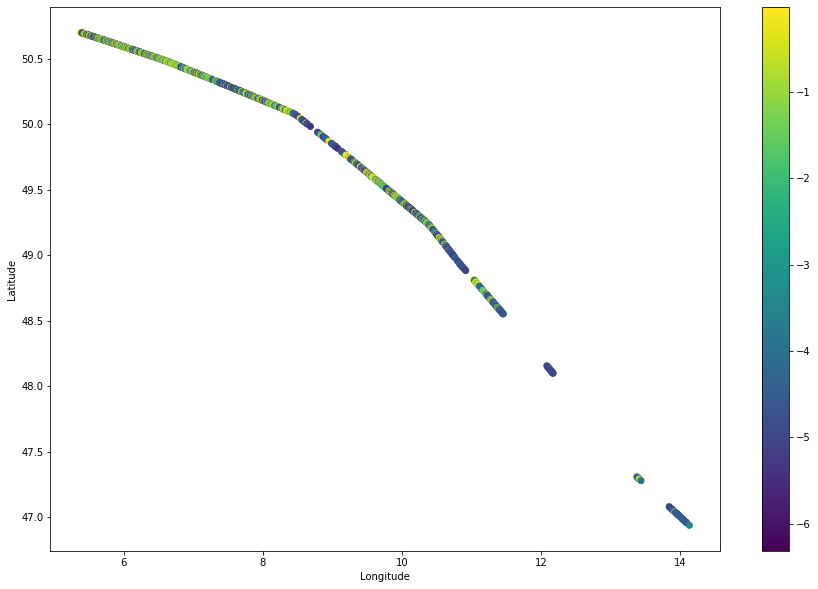

In [41]:
print('Aircraft number', r[2])

_ = filter_track(2,
             lat_gr=None, lat_ls=None,
             lon_gr=None, lon_ls=None,
             db1_eps=0.05, db1_n=5,
             k=3, rad=5,
             db2_eps=0.05, db2_n=5,
             plot='db2')

### Prepare 'base points' (filtered points) for the next step 4

In the solution of 33.6m I used all test tracks except the following: 1839, 2109, 1434, 1979, 2771. Adding the remaining 5 tracks increased a score to about 35m.

In [42]:
# Create a matrix of params to process all tracks

params = pd.DataFrame(columns=['id', 'lat_gr', 'lat_ls', 'lon_gr', 'lon_ls',
                               'db1_eps', 'db1_n', 'k', 'rad', 'db2_eps', 'db2_n'])
params.loc[0, :] = [0, None, None, None, None, 0.02, 5, 3, 10, 0.05, 5]
params.loc[1, :] = [1, None, None, None, None, 0.02, 5, 3, 10, 0.05, 5]
params.loc[2, :] = [2, None, None, None, None, 0.05, 5, 3, 5, 0.05, 5]
params.loc[3, :] = [3, None, None, 7.1, None, 0.02, 3, 3, 10, 0.05, 5]
params.loc[4, :] = [4, None, None, None, None, 0.02, 5, 3, 20, 0.1, 20]
params.loc[5, :] = [5, None, None, None, None, 0.02, 5, 3, 20, 0.05, 10]
params.loc[6, :] = [6, None, None, None, None, 0.02, 5, 3, 20, 0.05, 10]
params.loc[7, :] = [7, None, None, None, 8, 0.02, 5, 3, 20, 0.05, 15]
params.loc[8, :] = [8, None, None, None, None, 0.03, 5, 3, 20, 0.05, 7]
params.loc[9, :] = [9, 47, None, None, None, 0.03, 5, 3, 20, 0.05, 5]
params.loc[10, :] = [10, None, None, None, None, 0.015, 5, 3, 8, 0.05, 5]
params.loc[11, :] = [11, None, None, None, None, 0.05, 5, 3, 10, 0.1, 5]
params.loc[12, :] = [12, None, None, None, None, 0.02, 5, 3, 10, 0.08, 10]
params.loc[13, :] = [13, None, None, None, None, 0.1, 5, 3, 10, 0.2, 10]
params.loc[14, :] = [14, None, None, None, None, 0.1, 5, 3, 20, 0.3, 8]
params.loc[15, :] = [15, None, None, None, None, 0.02, 5, 3, 10, 0.2, 5]
params.loc[16, :] = [16, None, None, None, None, 0.01, 5, 5, 3, 0.3, 4]
params.loc[17, :] = [17, None, None, None, None, 0.02, 5, 3, 20, 0.05, 5]
params.loc[18, :] = [18, None, None, None, None, 0.02, 5, 3, 20, 0.3, 6]
params.loc[19, :] = [19, None, None, None, None, 0.03, 5, 2, 10, 0.05, 5]
params.loc[20, :] = [20, None, None, None, None, 0.04, 5, 4, 7, 0.3, 6]
params.loc[21, :] = [21, None, None, None, None, 0.04, 3, 3, 5, 0.05, 5]
params.loc[22, :] = [22, None, None, None, 9, 0.02, 5, 3, 1, 0.05, 5]
params.loc[23, :] = [23, None, None, None, None, 0.02, 5, 2, 3, 0.05, 5]
params.loc[24, :] = [24, None, None, None, 9, 0.03, 5, 3, 10, 0.05, 5]
params.loc[25, :] = [25, None, None, None, None, 0.02, 5, 3, 1, 0.05, 5]
params.loc[26, :] = [26, None, None, None, None, 0.02, 5, 3, 3, 0.05, 10]
params.loc[27, :] = [27, None, None, None, 8.5, 0.02, 5, 3, 5, 0.05, 10]
params.loc[28, :] = [28, None, None, None, None, 0.04, 5, 3, 5, 0.05, 5]
params.loc[29, :] = [29, None, None, None, None, 0.05, 5, 3, 3, 0.05, 5]
params.loc[30, :] = [30, None, None, None, None, 0.02, 5, 3, 10, 0.05, 5]
params.loc[31, :] = [31, None, None, None, None, 0.02, 5, 3, 5, 0.05, 7]

params

,id,lat_gr,lat_ls,lon_gr,lon_ls,db1_eps,db1_n,k,rad,db2_eps,db2_n
0,0,None,None,None,None,0.02,5,3,10,0.05,5
1,1,None,None,None,None,0.02,5,3,10,0.05,5
2,2,None,None,None,None,0.05,5,3,5,0.05,5
3,3,None,None,7.1,None,0.02,3,3,10,0.05,5
4,4,None,None,None,None,0.02,5,3,20,0.1,20
5,5,None,None,None,None,0.02,5,3,20,0.05,10
6,6,None,None,None,None,0.02,5,3,20,0.05,10
7,7,None,None,None,8,0.02,5,3,20,0.05,15
8,8,None,None,None,None,0.03,5,3,20,0.05,7
9,9,47,None,None,None,0.03,5,3,20,0.05,5


In [43]:
## Prepare base_points for step 4

base_points = pd.DataFrame()

for i in range(32):
    # do not include these tracks to achieve the best score
    if i in [0, 1, 21, 28, 31]:
        continue
    
    da = filter_track(*params.iloc[i].values)
    
    if base_points.shape[0] == 0:
        base_points = da.copy()
    else:
        base_points = pd.concat([base_points, da])
        
print(base_points.shape)

(31596, 12)


In [44]:
base_points.to_csv('base_points.csv')

# 4. Auto-selection of filtered locations from step 3 and extrapolation to the nearest points

Even after filtering, the selected "base points" have accuracy about 100m.

#### Description of the algorithm

Let's consider some neighbour points in some time neighborhood $(t_{0} - \Delta{t}, t_{0} + \Delta{t})$.
Let's assume that an aircraft track in this time neighborhood is a curve with constant curvature. **So if latitude
is a function of time, then it's a second degree polynome of time.** (Second derivative of latitude by time is constant). The same is valid for longitude.

Now, I can fit a second degree polynome of time to all base points' latitude and longitude from the neighborhood. In order to eliminate outliers I'll fit a Huber Regression instead of just Linear Regression applied to Polynomial features of time (see the code below).

Finally, I can estimate distances between initial locations and predicted ones. If a median value of distance error is below some predefined threshold, then the algorithm predicts locations to all points from this neighborhood and I assume that these points will have distance error below the threshold.

#### Time

Each record has several different time measurements from stations and the question is which one to select to predict a location. Stations are synchronized and clock shift between two stations is always less than 0.001s for all normal measurements (not outliers). Considering that aircraft speed is about 200m/s and desired location accuracy 1m, I deduce the maximum allowed time error to be 0.005s. So, I will consider only those points which maximum difference between time measurements is below 0.005s. Time value is calculated as an average across all time measurements for a point.  
 

#### Selection of algorithm parameters

The number of extrapolated points depends on the algorithm parameters. I found the following parameters to be reasonable which showed 33.6m score:
 - $\Delta{t}$ = 30s;
 - min number of points in the neighborhood = 10;
 - distance threshold = 35m

In [45]:
# Load base points from step 3

In [46]:
base_points = pd.read_csv('base_points.csv')
base_points.shape

(31596, 13)

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor

# Function to check points in some neighborhood and predict all locations if conditions satisfied
#
# Input:
#   - full: dataframe containing all points for a given aircraft track
#   - part: dataframe containing only base points for a given aircraft track
#   - t0: center of time neighborhood
#   - Teps: radius of time neighborhood
#   - Nmin: min number of points in the neighborhood required
#   - ds_max: distance threshold in meters
#
# Output:
#   - record id of the point with maximum time value in the neighborhood

def check_point(full, part, t0, Teps=30, Nmin=10, ds_max=50):
    # select points from the neighbourhood
    ii = np.where(abs(part.time.values - t0) < Teps)[0]
    
    if len(ii) < Nmin:
        return -1
    
    # Prepare polynomial features for time
    poly = PolynomialFeatures(2)
    t0 = np.min(part.time.values[ii])
    t = (part.time.values[ii] - t0).reshape(-1, 1)
    poly.fit(t)
    poly_t = poly.transform(t)

    # two huber regressions for latitude and longitude
    hr_lat = HuberRegressor().fit(poly_t, part.latitude.values[ii])
    hr_lon = HuberRegressor().fit(poly_t, part.longitude.values[ii])

    # Calculate distance errors for fitted points
    ds = np.array([dist3d(P3(lat, lon, hgt), P3(lat_pred, lon_pred, hgt)) for lat, lon, hgt, lat_pred, lon_pred in zip(part.latitude.values[ii],
                                                                                                     part.longitude.values[ii],
                                                                                                     part.geoAltitude.values[ii],
                                                                                                     hr_lat.predict(poly_t),
                                                                                                     hr_lon.predict(poly_t))])
    
    if np.median(ds) > ds_max:
        return -1
    
    # Predict locations in full
    id_min, id_max = np.min(part.id.values[ii]), np.max(part.id.values[ii])
    t_full = (full.loc[(full.id >= id_min) & (full.id <= id_max)].time.values - t0).reshape(-1, 1)
    poly_t_full = poly.transform(t_full)

    full.loc[(full.id >= id_min) & (full.id <= id_max), 'longitude'] = hr_lon.predict(poly_t_full)
    full.loc[(full.id >= id_min) & (full.id <= id_max), 'latitude'] = hr_lat.predict(poly_t_full)
    
    return id_max


### Run the algorithm

In [48]:
final = pd.DataFrame()

for aircraft in tqdm(base_points.aircraft.unique()):
    # prepare full dataframe
    full = df[df.aircraft==aircraft]
    # assign time values as average across all time measurements
    full['time'] = [np.mean([w[1]/1e9 for w in eval(y)]) for y in full['measurements']]
    # calculate max time difference to check outliers
    full['time_err'] = [np.max(np.abs(np.diff([w[1]/1e9 for w in eval(y)]))) for y in full['measurements']]
    # remove out;iers
    full = full[full.time_err<0.005]
    
    # prepare part dataframe
    part = base_points[base_points.aircraft==aircraft]
    # assign time values 
    part['time'] = [np.mean([w[1]/1e9 for w in eval(y)]) for y in part['measurements']]
    
    i = 0
    while i < part.shape[0]:
        try:  # sometimes HuberRegression doesn't converge
            id_max = check_point(full, part, part.time.values[i], Teps=30, Nmin=10, ds_max=35)
        except:
            # return unsuccess
            id_max = -1

        if id_max == -1:
            # unsuccess -> move to the next base point in track
            i += 1
        else:
            # success -> move to the next base point outside the neighborhood
            i = np.where(part.id.values == id_max)[0][0] + 1
            
    # save results
    if final.shape[0] == 0:
        final = full[~np.isnan(full.longitude)]
    else:
        final = pd.concat([final, full[~np.isnan(full.longitude)]])

100%|██████████| 27/27 [04:56<00:00, 10.97s/it]


In [49]:
# just fill in geoAltitude as it's not checked
final['geoAltitude'] = final['baroAltitude']
final.shape

(54985, 13)

In [50]:
## prepare submission

In [51]:
(pd.read_csv('test/round1_sample_empty.csv')
 .loc[:, ['id']]
 .merge(final.drop_duplicates('id'), on='id', how='left')
 .loc[:, ['id', 'latitude', 'longitude', 'geoAltitude']]
).to_csv('best_submission.csv', index=False)